# Using lapse probabilities and distributions in HSSM

Since v0.1.2, HSSM has added the ability to model outliers in the distribution with lapse probabilities and distributions. Let's see how it works.

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt

import hssm

hssm.set_floatX("float32")

Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


## Lapse probabilities and distributions are enabled by default.

From v0.1.2 on, lapse probabilities and distributions are enabled by default. If left unspecified, the probability for outliers will be a fixed value of 0.05 and the distribution will be specified as `Uniform(0, 10)`.

In [2]:
# Simulate some data

ddm_data = hssm.simulate_data(model="ddm", theta=[0.5, 1.5, 0.5, 0.1], size=1000)
ddm_data.head()

,rt,response
0,2.418014,1.0
1,1.416005,-1.0
2,0.499998,1.0
3,2.651997,-1.0
4,0.785995,-1.0


In [3]:
# Build the simplest model specifying only data
# Note the model output

ddm_model_default = hssm.HSSM(data=ddm_data)
ddm_model_default

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 1000

Parameters:

v:
    Prior: Uniform(lower: -10.0, upper: 10.0)
    Explicit bounds: None
a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: None
z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)
t:
    Prior: Uniform(lower: 0.0, upper: 2.0, initval: 0.10000000149011612)
    Explicit bounds: None

Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 10.0)

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p>
    Note in the above output that lapse probability and lapse distributions are at default values.
  </p>
</div>

## Specifying lapse probability and distribution

It is easy to change the lapse probability and distribution. HSSM has added two arguments, `p_outlier` and `lapse` to allow the lapse probability and distribution to be specified.

The optional `p_outlier` accepts a `float`, a `dict`, or a `bmb.Prior` object. When `p_outlier` is specified as a single `float` value, it will be considered "fixed". You can also specify a prior distribution for `p_outlier` through a `dict` or a `bmb.Prior` object, the same way as you would when specifying priors for any other parameter. That way, the lapse probability will be considered another parameter and will be estimated during MCMC sampling.

Likewise, the `lapse` argument accepts a `dict` or a `bmb.Prior` object to specify a fixed lapse distribution. This distribution will be considered as the one that outliers are generated from.

In [4]:
ddm_model_lapse = hssm.HSSM(
    data=ddm_data,
    p_outlier={"name": "Uniform", "lower": 0.01, "upper": 0.5},
    lapse=bmb.Prior("Uniform", lower=0.0, upper=20.0),
)

ddm_model_lapse

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 1000

Parameters:

v:
    Prior: Uniform(lower: -10.0, upper: 10.0)
    Explicit bounds: None
a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: None
z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)
t:
    Prior: Uniform(lower: 0.0, upper: 2.0, initval: 0.10000000149011612)
    Explicit bounds: None

Lapse probability: Uniform(lower: 0.009999999776482582, upper: 0.5)
Lapse distribution: Uniform(lower: 0.0, upper: 20.0)

In [5]:
lapse_trace = ddm_model_lapse.sample()
lapse_trace

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t, p_outlier, z, a, v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [6]:
az.summary(lapse_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t,0.138,0.023,0.094,0.178,0.001,0.000,1932.0,2128.0,1.0
p_outlier,0.019,0.008,0.010,0.033,0.000,0.000,2027.0,1548.0,1.0
z,0.501,0.013,0.478,0.525,0.000,0.000,2135.0,2450.0,1.0
a,1.484,0.027,1.434,1.534,0.001,0.000,2066.0,2291.0,1.0
v,0.524,0.033,0.463,0.586,0.001,0.001,2009.0,2129.0,1.0


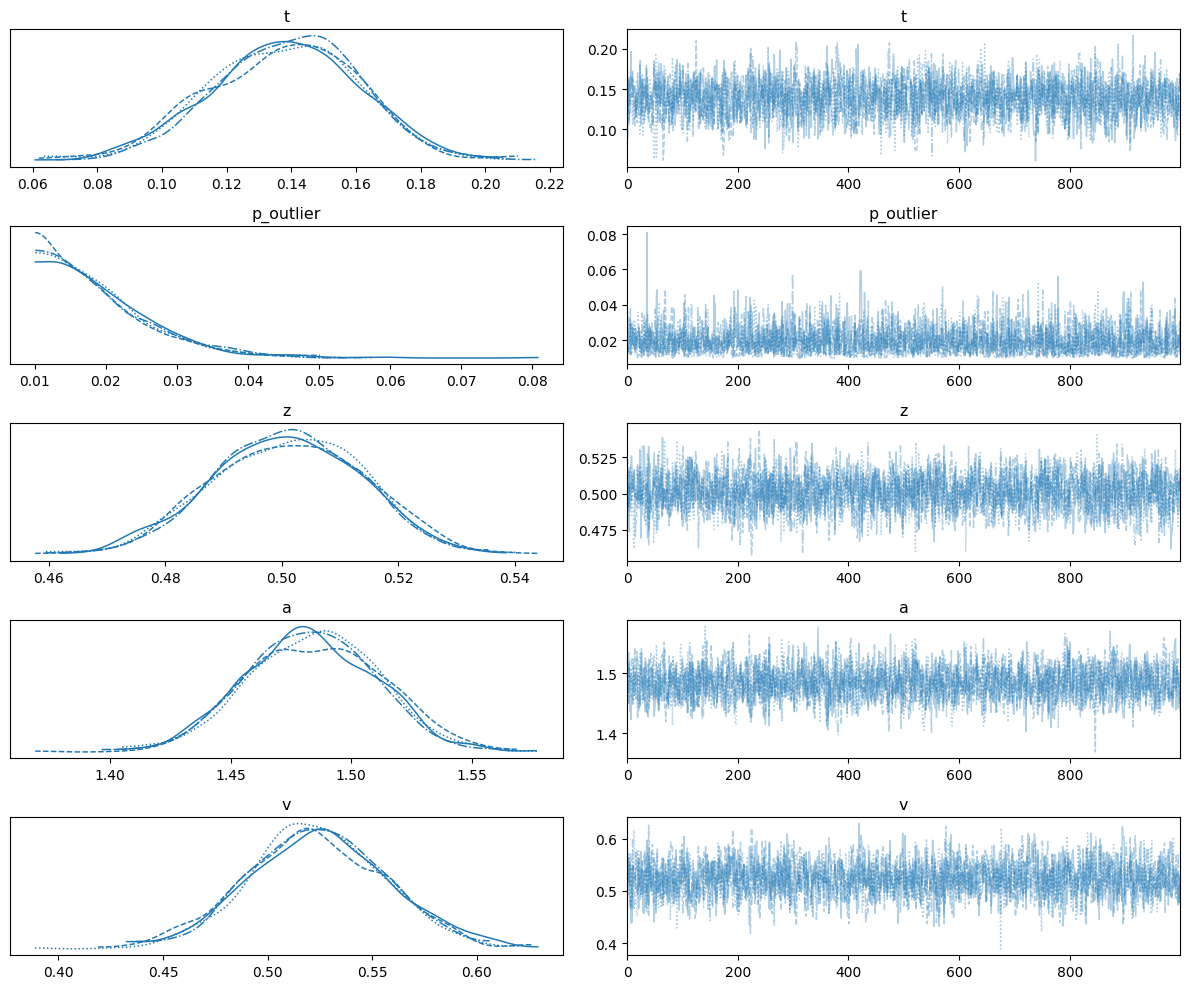

In [7]:
az.plot_trace(lapse_trace)
plt.tight_layout()

## Disable lapse probabilities and distributions

When `p_outliers` is set to `None` or 0, lapse probability and distributions will be ignored. They will not be included in the model output.

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p>
    If `p_outlier` is set to `None` or 0 but `lapse` is not set to None, you will receive a warning. Please remember to also set `lapse`Ï to `None`.
  </p>
</div>

In [8]:
ddm_model_no_lapse = hssm.HSSM(data=ddm_data, p_outlier=None, lapse=None)
ddm_model_no_lapse

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 1000

Parameters:

v:
    Prior: Uniform(lower: -10.0, upper: 10.0)
    Explicit bounds: None
a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: None
z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)
t:
    Prior: Uniform(lower: 0.0, upper: 2.0, initval: 0.10000000149011612)
    Explicit bounds: None

In [9]:
ddm_model_no_lapse_warn = hssm.HSSM(data=ddm_data, p_outlier=0)
ddm_model_no_lapse_warn

You have specified the `lapse` argument to include a lapse distribution, but `p_outlier` is set to either 0 or None. Your lapse distribution will be ignored.


Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 1000

Parameters:

v:
    Prior: Uniform(lower: -10.0, upper: 10.0)
    Explicit bounds: None
a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: None
z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)
t:
    Prior: Uniform(lower: 0.0, upper: 2.0, initval: 0.10000000149011612)
    Explicit bounds: None